In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Important Libraries**

### **Install**

In [ ]:
!pip install -q --no-cache-dir lightning torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 200.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.9/801.9 kB 186.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 138.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 180.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 111.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 169.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 108.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 66.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 109.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 155.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 129.2 MB/s eta 0:00:00
    

### **Import**

In [ ]:
try:
    import lightning as L
except:
    import lightning as L

from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from torchmetrics.classification import Accuracy

from IPython.display import Image as ColabImage

from PIL import Image

from typing import Any, Callable, List, Optional, Tuple

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data.dataloader import default_collate


from torchvision.ops import StochasticDepth, MLP, Permute
from torchvision.transforms import (
    Compose,
    RandAugment,
    ToTensor,
    Resize,
    Lambda
)
from torchvision.transforms.v2 import CutMix, MixUp, RandomChoice
from torchvision.datasets import VisionDataset
from torchvision.datasets.utils import (
    download_url,
    download_and_extract_archive
)

from functools import partial

import numpy as np
import matplotlib.pyplot as plt

import os
import cv2
import math
import copy
import time
import random
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

import cv2

## **Configuration**

In [ ]:
PATCH_SIZE            = [4, 4]
EMBED_DIM             = 96
DEPTHS                = [2, 2, 6, 2]
NUM_HEADS             = [3, 6, 12, 24]
WINDOW_SIZE           = [7, 7]
STOCHASTIC_DEPTH_PROB = 0.2

In [ ]:
IMAGE_SIZE  = 224
NUM_CLASSES = 256

In [ ]:
TRUNCATE_PER_CATEGORY = int(1e4)

In [ ]:
MOMENTUM = math.sqrt(6) / math.e
GOLDEN_RATIO = (1. + math.sqrt(5)) / 2.
EARLY_STOPPING_PATIENCE = 1 / 9

In [ ]:
WEIGHT_DECAY  = GOLDEN_RATIO  * 10 ** -math.pi
LEARNING_RATE = GOLDEN_RATIO  * 10 ** -math.e

In [ ]:
METRIC_TO_MONITOR = "val_acc"
METRIC_MODE       = "max"

In [ ]:
ACC_HISTORY     = dict()
LOSS_HISTORY    = dict()
MODEL_NAME      = dict()
MODEL           = dict()
BEST_MODEL_PATH = dict()

In [ ]:
os.makedirs("experiment", exist_ok=True)
os.makedirs("experiment/training", exist_ok=True)
os.makedirs("experiment/dataset", exist_ok=True)
os.makedirs("experiment/model", exist_ok=True)
EXPERIMENT_DIR = "experiment/"

In [ ]:
SEED = int(np.random.randint(2147483647))
print(f"Random seed: {SEED}")

Random seed: 1253769668


## **Dataset**

### **Utils**

In [ ]:
AUG_TRANSFORM = Compose(
    [
        RandAugment(),
        Resize((IMAGE_SIZE, IMAGE_SIZE)),
        ToTensor(),
        Lambda(lambda x: (x * 2) - 1),
    ]
)

TRANSFORM = Compose(
    [
        Resize((IMAGE_SIZE, IMAGE_SIZE)),
        ToTensor(),
        Lambda(lambda x: (x * 2) - 1),
    ]
)

In [ ]:
def AUG_COLLATE_FUNCTION(batch):
    return RandomChoice(
        [
            CutMix(num_classes=NUM_CLASSES),
            MixUp(num_classes=NUM_CLASSES),
        ]
    )(*default_collate(batch))

### **Load**

In [ ]:
import os
from torchvision.datasets import VisionDataset
from PIL import Image
from typing import Any, Callable, Optional, Tuple

class MyDataset(VisionDataset):
    def __init__(
        self,
        root: str,
        split: str,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        download: bool = False,
    ) -> None:
        super().__init__(root, transform=transform, target_transform=target_transform)

        assert split in ["train", "test", "val"], "Invalid split name. Choose 'train', 'test', or 'val'."

        self.split = split

        # Define the directory path based on split
        data_dir = os.path.join(root, split)

        # Assuming your classes are represented by folders in the data directory
        self.classes = sorted(os.listdir(data_dir))

        self.images = []
        self.labels = []

        # Iterate through classes
        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(data_dir, class_name)
            if os.path.isdir(class_dir):
                # Get image file paths
                image_files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith(".jpg")]
                self.images.extend(image_files)
                self.labels.extend([i] * len(image_files))

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        img = Image.open(self.images[index]).convert('RGB')
        label = self.labels[index]

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            label = self.target_transform(label)

        return img, label

    def __len__(self) -> int:
        return len(self.images)

# Usage:
# Define your transformations: TRANSFORM and AUG_TRANSFORM
# Define your dataset root directory
dataset_root = 'aug'

# Initialize your datasets
TrainDataset = MyDataset(
    root=dataset_root,
    split='train',
    transform=TRANSFORM,
    download=False,
)

TrainAugDataset = MyDataset(
    root=dataset_root,
    split='train',
    transform=AUG_TRANSFORM,
    download=False,
)

ValDataset = MyDataset(
    root=dataset_root,
    split='val',
    transform=TRANSFORM,
    download=False,
)

TestDataset = MyDataset(
    root=dataset_root,
    split='test',
    transform=TRANSFORM,
    download=False,
)


### **Data Distribution**

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

def visualize_distribution(root: str, num_classes: int):
    num_samples = list()
    categories = sorted(os.listdir(os.path.join(root, "train")))  # Assuming train directory contains class folders

    for i, c in enumerate(categories):
        if i == num_classes:
            break
        class_dir = os.path.join(root, "train", c)
        n = len([item for item in os.listdir(class_dir) if item.endswith(".jpg")])
        num_samples.append(n)

    categories = [cat.replace("_", " ") for cat in categories[:num_classes]]  # Assuming categories are folder names

    # Create bar plot
    plt.bar(categories, num_samples)

    # Customize labels and title
    plt.xlabel('Categories')
    plt.ylabel('Samples')
    plt.title('Dataset Data Distribution')

    plt.xticks(fontsize=10, rotation=90)

    img_path = os.path.join(root, "data_distribution.png")

    plt.tight_layout()
    plt.savefig(img_path)
    plt.clf()

    # Show the image using OpenCV
    # img = cv2.imread(img_path)
    # cv2_imshow('Data Distribution', img)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

# Usage:
# Define the root directory of your dataset
dataset_root = 'aug'

# Define the number of classes you want to visualize
num_classes = 4  # Adjust this according to your dataset

# Visualize the distribution
visualize_distribution(dataset_root, num_classes)


<Figure size 640x480 with 0 Axes>

## **Model**

### **Utils**

In [ ]:
class AvgMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.scores = list()

    def update(self, val):
        self.scores.append(val)

    def show(self):
        scores = torch.stack(self.scores)
        return torch.mean(scores)

### **Swin Transformer**  Network Starts here

#### **Module**

In [ ]:
def _patch_merging_pad(x: torch.Tensor) -> torch.Tensor:
    H, W, _ = x.shape[-3:]
    x = F.pad(x, (0, 0, 0, W % 2, 0, H % 2))
    x0 = x[..., 0::2, 0::2, :]  # ... H/2 W/2 C
    x1 = x[..., 1::2, 0::2, :]  # ... H/2 W/2 C
    x2 = x[..., 0::2, 1::2, :]  # ... H/2 W/2 C
    x3 = x[..., 1::2, 1::2, :]  # ... H/2 W/2 C
    x = torch.cat([x0, x1, x2, x3], -1)  # ... H/2 W/2 4*C
    return x

In [ ]:
def _get_relative_position_bias(
    relative_position_bias_table: torch.Tensor,
    relative_position_index: torch.Tensor,
    window_size: List[int],
) -> torch.Tensor:
    N = window_size[0] * window_size[1]
    relative_position_bias = relative_position_bias_table[
        relative_position_index
    ]
    relative_position_bias = relative_position_bias.view(N, N, -1)
    relative_position_bias = (
        relative_position_bias.permute(2, 0, 1).contiguous().unsqueeze(0)
    )
    return relative_position_bias

In [ ]:
class PatchMerging(nn.Module):
    """Patch Merging Layer.
    Args:
        dim (int): Number of input channels.
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
    """

    def __init__(
        self,
        dim: int,
        norm_layer: Callable[..., nn.Module] = nn.LayerNorm,
    ):
        super().__init__()

        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x: torch.Tensor):
        """
        Args:
            x (Tensor): input tensor with expected layout of [..., H, W, C]
        Returns:
            Tensor with layout of [..., H/2, W/2, 2*C]
        """
        x = _patch_merging_pad(x)
        x = self.norm(x)
        x = self.reduction(x)  # ... H/2 W/2 2*C
        return x

In [ ]:
def shifted_window_attention(
    input: torch.Tensor,
    qkv_weight: torch.Tensor,
    proj_weight: torch.Tensor,
    relative_position_bias: torch.Tensor,
    window_size: List[int],
    num_heads: int,
    shift_size: List[int],
    qkv_bias: Optional[torch.Tensor] = None,
    proj_bias: Optional[torch.Tensor] = None,
) -> torch.Tensor:
    """
    Window based multi-head self attention (W-MSA) module with relative position
    bias. It supports both of shifted and non-shifted window.
    Args:
        input (Tensor[N, H, W, C]): The input tensor or 4-dimensions.
        qkv_weight (Tensor[in_dim, out_dim]): The weight tensor of query,
                                              key, value.
        proj_weight (Tensor[out_dim, out_dim]): The weight tensor of projection.
        relative_position_bias (Tensor): The learned relative position
                                         bias added to attention.
        window_size (List[int]): Window size.
        num_heads (int): Number of attention heads.
        shift_size (List[int]): Shift size for shifted window attention.
        qkv_bias (Tensor[out_dim], optional): The bias tensor of query, key,
                                              value. Default: None.
        proj_bias (Tensor[out_dim], optional): The bias tensor of projection.
                                               Default: None.
    Returns:
        Tensor[N, H, W, C]: The output tensor after shifted window attention.
    """
    B, H, W, C = input.shape
    # pad feature maps to multiples of window size
    pad_r = (window_size[1] - W % window_size[1]) % window_size[1]
    pad_b = (window_size[0] - H % window_size[0]) % window_size[0]
    x = F.pad(input, (0, 0, 0, pad_r, 0, pad_b))
    _, pad_H, pad_W, _ = x.shape

    shift_size = shift_size.copy()
    # If window size is larger than feature size, there is no need to
    # shift window
    if window_size[0] >= pad_H:
        shift_size[0] = 0
    if window_size[1] >= pad_W:
        shift_size[1] = 0

    # cyclic shift
    if sum(shift_size) > 0:
        x = torch.roll(x, shifts=(-shift_size[0], -shift_size[1]), dims=(1, 2))

    # partition windows
    num_windows = (pad_H // window_size[0]) * (pad_W // window_size[1])
    x = x.view(
        B,
        pad_H // window_size[0],
        window_size[0],
        pad_W // window_size[1],
        window_size[1],
        C,
    )
    x = x.permute(0, 1, 3, 2, 4, 5).reshape(
        B * num_windows, window_size[0] * window_size[1], C
    )  # B*nW, Ws*Ws, C

    # multi-head attention
    qkv = F.linear(x, qkv_weight, qkv_bias)
    qkv = qkv.reshape(
        x.size(0), x.size(1), 3, num_heads, C // num_heads
    ).permute(
        2, 0, 3, 1, 4
    )
    q, k, v = qkv[0], qkv[1], qkv[2]
    q = q * (C // num_heads) ** -0.5
    attn = q.matmul(k.transpose(-2, -1))

    # add relative position bias
    attn = attn + relative_position_bias

    if sum(shift_size) > 0:
        # generate attention mask
        attn_mask = x.new_zeros((pad_H, pad_W))
        h_slices = (
            (0, -window_size[0]),
            (-window_size[0], -shift_size[0]),
            (-shift_size[0], None),
        )
        w_slices = (
            (0, -window_size[1]),
            (-window_size[1], -shift_size[1]),
            (-shift_size[1], None),
        )
        count = 0
        for h in h_slices:
            for w in w_slices:
                attn_mask[h[0] : h[1], w[0] : w[1]] = count
                count += 1
        attn_mask = attn_mask.view(
            pad_H // window_size[0],
            window_size[0],
            pad_W // window_size[1],
            window_size[1],
        )
        attn_mask = attn_mask.permute(0, 2, 1, 3).reshape(
            num_windows, window_size[0] * window_size[1]
        )
        attn_mask = attn_mask.unsqueeze(1) - attn_mask.unsqueeze(2)
        attn_mask = attn_mask.masked_fill(
            attn_mask != 0, float(-100.0)
        ).masked_fill(
            attn_mask == 0, float(0.0)
        )
        attn = attn.view(
            x.size(0) // num_windows,
            num_windows,
            num_heads,
            x.size(1),
            x.size(1),
        )
        attn = attn + attn_mask.unsqueeze(1).unsqueeze(0)
        attn = attn.view(-1, num_heads, x.size(1), x.size(1))

    attn = F.softmax(attn, dim=-1)

    x = attn.matmul(v).transpose(1, 2).reshape(x.size(0), x.size(1), C)
    x = F.linear(x, proj_weight, proj_bias)

    # reverse windows
    x = x.view(
        B,
        pad_H // window_size[0],
        pad_W // window_size[1],
        window_size[0],
        window_size[1],
        C,
    )
    x = x.permute(0, 1, 3, 2, 4, 5).reshape(B, pad_H, pad_W, C)

    # reverse cyclic shift
    if sum(shift_size) > 0:
        x = torch.roll(x, shifts=(shift_size[0], shift_size[1]), dims=(1, 2))

    # unpad features
    x = x[:, :H, :W, :].contiguous()
    return x

In [ ]:
class ShiftedWindowAttention(nn.Module):
    """
    See :func:`shifted_window_attention`.
    """

    def __init__(
        self,
        dim: int,
        window_size: List[int],
        shift_size: List[int],
        num_heads: int,
        qkv_bias: bool = True,
        proj_bias: bool = True,
    ):
        super().__init__()
        if len(window_size) != 2 or len(shift_size) != 2:
            raise ValueError("window_size and shift_size must be of length 2")
        self.window_size = window_size
        self.shift_size = shift_size
        self.num_heads = num_heads

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.proj = nn.Linear(dim, dim, bias=proj_bias)

        self.define_relative_position_bias_table()
        self.define_relative_position_index()

    def define_relative_position_bias_table(self):
        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros(
                (2 * self.window_size[0] - 1) * (2 * self.window_size[1] - 1),
                self.num_heads,
            )
        )  # 2*Wh-1 * 2*Ww-1, nH
        nn.init.trunc_normal_(self.relative_position_bias_table, std=0.02)

    def define_relative_position_index(self):
        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(
            torch.meshgrid(coords_h, coords_w, indexing="ij")
        )  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = (
            coords_flatten[:, :, None] - coords_flatten[:, None, :]
        )  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(
            1, 2, 0
        ).contiguous()  # Wh*Ww, Wh*Ww, 2
        # shift to start from 0
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        # Wh*Ww*Wh*Ww
        relative_position_index = relative_coords.sum(-1).flatten()
        self.register_buffer("relative_position_index", relative_position_index)

    def get_relative_position_bias(self) -> torch.Tensor:
        return _get_relative_position_bias(
            self.relative_position_bias_table,
            self.relative_position_index,
            self.window_size,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (Tensor): Tensor with layout of [B, H, W, C]
        Returns:
            Tensor with same layout as input, i.e. [B, H, W, C]
        """
        relative_position_bias = self.get_relative_position_bias()
        return shifted_window_attention(
            x,
            self.qkv.weight,
            self.proj.weight,
            relative_position_bias,
            self.window_size,
            self.num_heads,
            shift_size=self.shift_size,
            qkv_bias=self.qkv.bias,
            proj_bias=self.proj.bias,
        )

In [ ]:
class SpatialInteractionBlock(nn.Module):
    def __init__(self, dim, num_heads, window_size, shift_size, mlp_ratio=4.0, norm_layer=nn.LayerNorm, attn_layer=ShiftedWindowAttention):
        super().__init__()
        self.norm = norm_layer(dim)
        self.attn = attn_layer(dim, window_size, shift_size, num_heads)
        self.mlp = MLP(dim, [int(dim * mlp_ratio), dim])

    def forward(self, x):
        # Apply spatial attention
        residual = x
        x = self.norm(x)
        x = self.attn(x)
        x = x + residual  # Residual connection

        # Apply MLP
        residual = x
        x = self.norm(x)
        x = self.mlp(x)
        x = x + residual  # Residual connection

        return x


In [ ]:
class SwinTransformerBlock(nn.Module):
    def __init__(
        self,
        dim,
        num_heads,
        window_size,
        shift_size,
        mlp_ratio=4.0,
        stochastic_depth_prob=0.0,
        norm_layer=nn.LayerNorm,
        attn_layer=ShiftedWindowAttention,
        spatial_interaction_block=None  # Add spatial interaction block
    ):
        super().__init__()

        self.norm1 = norm_layer(dim)
        self.attn = attn_layer(dim, window_size, shift_size, num_heads)
        self.stochastic_depth = StochasticDepth(stochastic_depth_prob, "row")
        self.norm2 = norm_layer(dim)
        self.mlp = MLP(dim, [int(dim * mlp_ratio), dim],
                                   activation_layer=nn.GELU
)

        if spatial_interaction_block is not None:
            self.spatial_interaction = spatial_interaction_block(dim, num_heads, window_size, shift_size, mlp_ratio, norm_layer, attn_layer)
        else:
            self.spatial_interaction = None

    def forward(self, x):
        # Residual connection for attention block
        residual = x
        x = self.stochastic_depth(self.attn(self.norm1(x)))
        x = x + residual

        if self.spatial_interaction is not None:
            # Apply spatial interaction block
            x = self.spatial_interaction(x)

        # Residual connection for MLP block
        residual = x
        x = self.stochastic_depth(self.mlp(self.norm2(x)))
        x = x + residual

        return x


In [ ]:
class SwinTransformer(nn.Module):
    """
    Implements Swin Transformer from the `"Swin Transformer:
    Hierarchical Vision Transformer using Shifted Windows"
    <https://arxiv.org/abs/2103.14030>`_ paper.
    Args:
        patch_size (List[int]): Patch size.
        embed_dim (int): Patch embedding dimension.
        depths (List(int)): Depth of each Swin Transformer layer.
        num_heads (List(int)): Number of attention heads in different layers.
        window_size (List[int]): Window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
                           Default: 4.0.
        stochastic_depth_prob (float): Stochastic depth rate. Default: 0.1.
        num_classes (int): Number of classes for classification head.
                           Default: NUM_CLASSES.
        block (nn.Module, optional): SwinTransformer Block. Default: None.
        norm_layer (nn.Module, optional): Normalization layer. Default: None.
        downsample_layer (nn.Module): Downsample layer (patch merging).
                                      Default: PatchMerging.
    """

    def __init__(
        self,
        patch_size: List[int],
        embed_dim: int,
        depths: List[int],
        num_heads: List[int],
        window_size: List[int],
        mlp_ratio: float = 4.0,
        stochastic_depth_prob: float = 0.1,
        num_classes: int = NUM_CLASSES,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        block: Optional[Callable[..., nn.Module]] = None,
        downsample_layer: Callable[..., nn.Module] = PatchMerging,
    ):
        super().__init__()
        self.num_classes = num_classes

        if block is None:
            block = SwinTransformerBlock
        if norm_layer is None:
            norm_layer = partial(nn.LayerNorm, eps=1e-5)

        layers: List[nn.Module] = []
        # split image into non-overlapping patches
        layers.append(
            nn.Sequential(
                nn.Conv2d(
                    3,
                    embed_dim,
                    kernel_size=(patch_size[0], patch_size[1]),
                    stride=(patch_size[0], patch_size[1]),
                ),
                Permute([0, 2, 3, 1]),
                norm_layer(embed_dim),
            )
        )

        total_stage_blocks = sum(depths)
        stage_block_id = 0
        # build SwinTransformer blocks
        for i_stage in range(len(depths)):
            stage: List[nn.Module] = []
            dim = embed_dim * 2**i_stage
            for i_layer in range(depths[i_stage]):
                # adjust stochastic depth probability based on the depth of the
                # stage block
                sd_prob = (
                    stochastic_depth_prob
                    * float(stage_block_id)
                    / (total_stage_blocks - 1)
                )
                stage.append(
                    block(
                        dim,
                        num_heads[i_stage],
                        window_size=window_size,
                        shift_size=[
                            0
                            if i_layer % 2 == 0 else w // 2
                            for w in window_size
                        ],
                        mlp_ratio=mlp_ratio,
                        stochastic_depth_prob=sd_prob,
                        norm_layer=norm_layer,
                    )
                )
                stage_block_id += 1
            layers.append(nn.Sequential(*stage))
            # add patch merging layer
            if i_stage < (len(depths) - 1):
                layers.append(downsample_layer(dim, norm_layer))
        self.features = nn.Sequential(*layers)

        num_features = embed_dim * 2 ** (len(depths) - 1)
        self.norm = norm_layer(num_features)
        self.permute = Permute([0, 3, 1, 2])  # B H W C -> B C H W
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten(1)
        self.classifier = nn.Linear(num_features, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.features(x)
        x = self.norm(x)
        x = self.permute(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

#### **Get Model**

In [ ]:
def _swin_transformer(
    patch_size: List[int],
    embed_dim: int,
    depths: List[int],
    num_heads: List[int],
    window_size: List[int],
    stochastic_depth_prob: float,
    pretrained: bool=True,
) -> SwinTransformer:

    model = SwinTransformer(
        patch_size=patch_size,
        embed_dim=embed_dim,
        depths=depths,
        num_heads=num_heads,
        window_size=window_size,
        stochastic_depth_prob=stochastic_depth_prob,
    )

    if pretrained:
        download_url(
            url="https://download.pytorch.org/models/swin_t-704ceda3.pth",
            root="experiment/model",
            filename="swin_t-704ceda3.pth",
        )

        model.load_state_dict(
            torch.load("experiment/model/swin_t-704ceda3.pth"),
            strict=False,
        )

    return model

In [ ]:
class NoAugmentation(L.LightningModule):
    def __init__(self):
        super().__init__()

        self.batch_size = 256
        self.max_epoch = 100
        self.lr = 0.001
        self.lr_now = self.lr * 1e3

        self.arch = _swin_transformer(
            patch_size=PATCH_SIZE,
            embed_dim=EMBED_DIM,
            depths=DEPTHS,
            num_heads=NUM_HEADS,
            window_size=WINDOW_SIZE,
            stochastic_depth_prob=STOCHASTIC_DEPTH_PROB,
        )

        self.automatic_optimization = False

        self.train_accuracy = Accuracy(
            task="multiclass",
            num_classes=NUM_CLASSES,
        )
        self.val_accuracy = Accuracy(
            task="multiclass",
            num_classes=NUM_CLASSES,
        )

        self.test_accuracy = Accuracy(
            task="multiclass",
            num_classes=NUM_CLASSES,
        )
        self.test_accuracy_top5 = Accuracy(
            task="multiclass",
            top_k=5,
            num_classes=NUM_CLASSES,
        )

        self.train_loss = list()
        self.val_loss = list()

        self.train_acc = list()
        self.val_acc = list()

        self.train_loss_recorder = AvgMeter()
        self.val_loss_recorder = AvgMeter()

        self.train_acc_recorder = AvgMeter()
        self.val_acc_recorder = AvgMeter()

        self.sanity_check_counter = 1

    def forward(self, x):
        return self.arch(x)

    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        y = y.view(y.shape[0])
        loss = F.cross_entropy(y_hat, y)
        self.train_accuracy.update(y_hat.softmax(1), y)
        acc = self.train_accuracy.compute().data.cpu()

        opt = self.optimizers()
        opt.zero_grad()
        self.manual_backward(loss)
        opt.step()

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)

        self.train_loss_recorder.update(loss.data)
        self.train_acc_recorder.update(acc)

    def on_train_epoch_end(self):
        self.train_loss.append(
            self.train_loss_recorder.show().data.cpu().numpy(),
        )
        self.train_loss_recorder = AvgMeter()

        self.train_acc.append(self.train_acc_recorder.show().data.cpu().numpy())
        self.train_acc_recorder = AvgMeter()

        sch = self.lr_schedulers()
        sch.step()

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        y = y.view(y.shape[0])
        loss = F.cross_entropy(y_hat, y)

        if self.sanity_check_counter == 0:
            self.val_accuracy.update(y_hat.softmax(1), y)
            acc = self.val_accuracy.compute().data.cpu()

            self.log("val_loss", loss, prog_bar=True)
            self.log("val_acc", acc, prog_bar=True)

            self.val_loss_recorder.update(loss.data)
            self.val_acc_recorder.update(acc)

    def on_validation_epoch_end(self):
        if self.sanity_check_counter == 0:
            self.val_loss.append(
                self.val_loss_recorder.show().data.cpu().numpy()
            )
            self.val_loss_recorder = AvgMeter()
            acc = self.val_acc_recorder.show().data.cpu().numpy()
            lr_now_ = self.optimizers().param_groups[0]["lr"]
            if self.lr_now > lr_now_:
                self.lr_now = lr_now_
                report_str = f"[{MODEL_NAME['no_aug']}] Learning Rate Changed:"
                report_str += f" {lr_now_} - Epoch: {self.current_epoch}"
                print(report_str)
            self.val_acc.append(acc)
            self.val_acc_recorder = AvgMeter()
        else:
            self.sanity_check_counter -= 1

    def test_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        y = y.view(y.shape[0])
        loss = F.cross_entropy(y_hat, y)
        self.test_accuracy.update(y_hat.softmax(1), y)
        self.test_accuracy_top5.update(y_hat.softmax(1), y)

        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log(
            "test_acc_top1",
            self.test_accuracy.compute(),
            prog_bar=True,
            logger=True,
        )
        self.log(
            "test_acc_top5",
            self.test_accuracy_top5.compute(),
            prog_bar=True,
            logger=True,
        )

    def on_train_end(self):
        # Loss
        loss_img_file = (
            f"experiment/training/{MODEL_NAME['no_aug']}_loss_plot.png"
        )
        plt.plot(self.train_loss, color="r", label="train")
        plt.plot(self.val_loss, color="b", label="validation")
        plt.title("Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.savefig(loss_img_file)
        plt.clf()
        img = cv2.imread(loss_img_file)
        # cv2_imshow(img)
        plt.imshow(img)
        plt.axis('off')  # Turn off axis for better visualization
        plt.show()

        LOSS_HISTORY["no_aug"] = self.val_loss

        # Accuracy
        acc_img_file = (
            f"experiment/training/{MODEL_NAME['no_aug']}_acc_plot.png"
        )
        plt.plot(self.train_acc, color="r", label="train")
        plt.plot(self.val_acc, color="b", label="validation")
        plt.title("Accuracy Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid()
        plt.savefig(acc_img_file)
        plt.clf()
        img = cv2.imread(acc_img_file)
        # cv2_imshow(img)
        plt.imshow(img)
        plt.axis('off')  # Turn off axis for better visualization
        plt.show()

        ACC_HISTORY["no_aug"] = self.val_acc

    def train_dataloader(self):
        return data.DataLoader(
            dataset=TrainDataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=4
        )

    def val_dataloader(self):
        return data.DataLoader(
            dataset=ValDataset,
            batch_size=self.batch_size,
            shuffle=False,
        )

    def test_dataloader(self):
        return data.DataLoader(
            dataset=TestDataset,
            batch_size=1,
            shuffle=False,
        )

    def configure_optimizers(self):
        optimizer = optim.SGD(
            self.parameters(),
            lr=self.lr,
            momentum=MOMENTUM,
            weight_decay=WEIGHT_DECAY,
            nesterov=True,
        )
        lr_scheduler = {
            "scheduler": optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                self.max_epoch,
            ),
            "name": "lr_scheduler",
        }

        return [optimizer], [lr_scheduler]

In [ ]:
MODEL["no_aug"] = NoAugmentation
MODEL_NAME["no_aug"] = MODEL["no_aug"].__name__
BEST_MODEL_PATH["no_aug"] = os.path.join(
    EXPERIMENT_DIR,
    "model",
    f"{MODEL_NAME['no_aug']}_best.ckpt",
)

Global seed set to 1253769668


NoAugmentation


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Using downloaded and verified file: experiment/model/swin_t-704ceda3.pth


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name               | Type               | Params
----------------------------------------------------------
0 | arch               | SwinTransformer    | 27.7 M
1 | train_accuracy     | MulticlassAccuracy | 0     
2 | val_accuracy       | MulticlassAccuracy | 0     
3 | test_accuracy      | MulticlassAccuracy | 0     
4 | test_accuracy_top5 | MulticlassAccuracy | 0     
----------------------------------------------------------
27.7 M    Trainable params
0         Non-trainable params
27.7 M    Total params
110.865   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.001 - Epoch: 0


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0009997532801828658 - Epoch: 1


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0009990133642141358 - Epoch: 2


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.00099778098230154 - Epoch: 3


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.000996057350657239 - Epoch: 4


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0009938441702975688 - Epoch: 5


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0009911436253643444 - Epoch: 6


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0009879583809693736 - Epoch: 7


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0009842915805643154 - Epoch: 8


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0009801468428384714 - Epoch: 9


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0009755282581475767 - Epoch: 10


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0009704403844771127 - Epoch: 11


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0009648882429441257 - Epoch: 12


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0009588773128419905 - Epoch: 13


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0009524135262330098 - Epoch: 14


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0009455032620941839 - Epoch: 15


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0009381533400219318 - Epoch: 16


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0009303710135019719 - Epoch: 17


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0009221639627510076 - Epoch: 18


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.000913540287137281 - Epoch: 19


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0009045084971874739 - Epoch: 20


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0008950775061878452 - Epoch: 21


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0008852566213878947 - Epoch: 22


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0008750555348152298 - Epoch: 23


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0008644843137107057 - Epoch: 24


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0008535533905932737 - Epoch: 25


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0008422735529643444 - Epoch: 26


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0008306559326618259 - Epoch: 27


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0008187119948743449 - Epoch: 28


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0008064535268264883 - Epoch: 29


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0007938926261462367 - Epoch: 30


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0007810416889260654 - Epoch: 31


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0007679133974894983 - Epoch: 32


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0007545207078751857 - Epoch: 33


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0007408768370508577 - Epoch: 34


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0007269952498697734 - Epoch: 35


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0007128896457825364 - Epoch: 36


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0006985739453173903 - Epoch: 37


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0006840622763423391 - Epoch: 38


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0006693689601226458 - Epoch: 39


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0006545084971874737 - Epoch: 40


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0006394955530196147 - Epoch: 41


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0006243449435824273 - Epoch: 42


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0006090716206982714 - Epoch: 43


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0005936906572928625 - Epoch: 44


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0005782172325201156 - Epoch: 45


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0005626666167821523 - Epoch: 46


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0005470541566592572 - Epoch: 47


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0005313952597646569 - Epoch: 48


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0005157053795390643 - Epoch: 49


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0005000000000000002 - Epoch: 50


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.00048429462046093607 - Epoch: 51


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0004686047402353435 - Epoch: 52


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.000452945843340743 - Epoch: 53


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.00043733338321784806 - Epoch: 54


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0004217827674798847 - Epoch: 55


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.00040630934270713783 - Epoch: 56


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.000390928379301729 - Epoch: 57


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0003756550564175727 - Epoch: 58


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.00036050444698038553 - Epoch: 59


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.00034549150281252655 - Epoch: 60


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0003306310398773544 - Epoch: 61


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.00031593772365766127 - Epoch: 62


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0003014260546826097 - Epoch: 63


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0002871103542174637 - Epoch: 64


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0002730047501302267 - Epoch: 65


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.00025912316294914234 - Epoch: 66


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0002454792921248144 - Epoch: 67


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.00023208660251050164 - Epoch: 68


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.00021895831107393473 - Epoch: 69


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.00020610737385376356 - Epoch: 70


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.00019354647317351177 - Epoch: 71


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0001812880051256552 - Epoch: 72


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.00016934406733817422 - Epoch: 73


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0001577264470356557 - Epoch: 74


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.00014644660940672634 - Epoch: 75


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0001355156862892944 - Epoch: 76


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.00012494446518477025 - Epoch: 77


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.00011474337861210548 - Epoch: 78


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.00010492249381215483 - Epoch: 79


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 9.549150281252637e-05 - Epoch: 80


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 8.645971286271918e-05 - Epoch: 81


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 7.78360372489926e-05 - Epoch: 82


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 6.962898649802815e-05 - Epoch: 83


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 6.184665997806824e-05 - Epoch: 84


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 5.449673790581613e-05 - Epoch: 85


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 4.758647376699034e-05 - Epoch: 86


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 4.112268715800956e-05 - Epoch: 87


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 3.511175705587434e-05 - Epoch: 88


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 2.9559615522887284e-05 - Epoch: 89


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 2.447174185242324e-05 - Epoch: 90


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 1.9853157161528526e-05 - Epoch: 91


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 1.570841943568452e-05 - Epoch: 92


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 1.204161903062634e-05 - Epoch: 93


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 8.85637463565564e-06 - Epoch: 94


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 6.155829702431171e-06 - Epoch: 95


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 3.942649342761118e-06 - Epoch: 96


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 2.2190176984600023e-06 - Epoch: 97


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 9.866357858642206e-07 - Epoch: 98


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 2.467198171342e-07 - Epoch: 99


Validation: 0it [00:00, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0 - Epoch: 100


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.


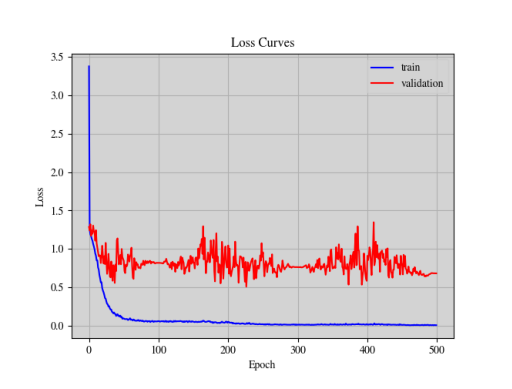

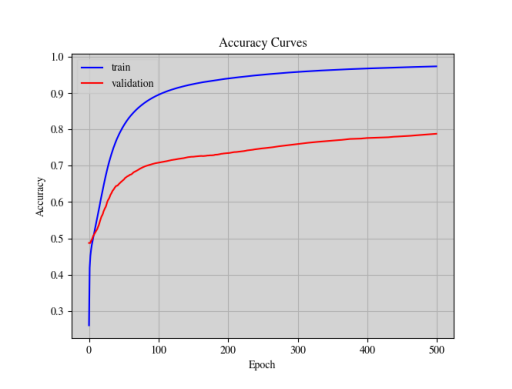

In [ ]:
def _train_loop():
    seed_everything(SEED, workers=True)

    print(MODEL_NAME['no_aug'])
    model = MODEL['no_aug']()

    callbacks = list()

    checkpoint = ModelCheckpoint(
        monitor=METRIC_TO_MONITOR,
        dirpath=f"{EXPERIMENT_DIR}/model",
        mode=METRIC_MODE,
        filename=f"{MODEL_NAME['no_aug']}_best",
    )
    callbacks.append(checkpoint)

    early_stopping = EarlyStopping(
        monitor=METRIC_TO_MONITOR,
        min_delta=0.00,
        patience=int(
            EARLY_STOPPING_PATIENCE * EPOCH
        ),
        verbose=False,
        mode=METRIC_MODE,
    )
    callbacks.append(early_stopping)

    if os.path.exists(BEST_MODEL_PATH["no_aug"]):
        ckpt_path = BEST_MODEL_PATH["no_aug"]
    else:
        ckpt_path = None

    trainer = Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=500,
        logger=False,
        callbacks=callbacks,
        log_every_n_steps=5,
    )
    trainer.fit(model, ckpt_path=ckpt_path)

_train_loop()